In [117]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk

RANDOM_SEED = 42
# nltk.download('averaged_perceptron_tagger')

# Specify each path

In [118]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [119]:
# Change training classes if necessary
# NUM_CLASSES = 3

# Dataset reading

In [120]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [121]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2]), array([21, 18, 16], dtype=int64))


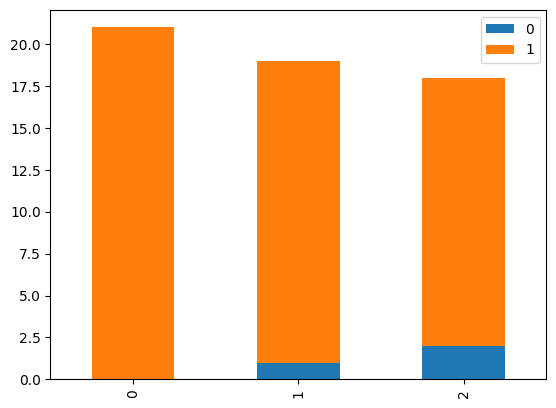

In [123]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

In [124]:
NUM_CLASSES = len(counts[0])
NUM_CLASSES

3

# Model building

In [125]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [126]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 5

In [127]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [128]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [129]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/100
1/1 [==============================] - 1s 901ms/step - loss: 1.2653 - accuracy: 0.0000e+00 - val_loss: 1.2456 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.24565, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/100
1/1 [==============================] - 0s 77ms/step - loss: 1.2358 - accuracy: 0.0488 - val_loss: 1.2168 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 1.24565 to 1.21677, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 1.2080 - accuracy: 0.0488 - val_loss: 1.1888 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 1.21677 to 1.18876, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 1.1813 - accuracy: 0.0732 - val_loss: 1.1624 - val_accuracy: 0.0714

Epoch 00004: val_loss improved from 1.18876 to 1.16236

In [130]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [131]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

1/1 [==============================] - 0s 77ms/step - loss: 0.1475 - accuracy: 1.0000


In [132]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.00692671 0.72277653 0.2702968 ]
1


# Confusion matrix

In [133]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report
#
# def print_confusion_matrix(y_true, y_pred, report=True):
#     labels = sorted(list(set(y_true)))
#     cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
#
#     df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
#
#     fig, ax = plt.subplots(figsize=(7, 6))
#     sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
#     ax.set_ylim(len(set(y_true)), 0)
#     plt.show()
#
#     if report:
#         print('Classification Report')
#         print(classification_report(y_test, y_pred))
#
# Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)
#
# print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [134]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [135]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Zilan\AppData\Local\Temp\tmpwzilfpbz\assets


INFO:tensorflow:Assets written to: C:\Users\Zilan\AppData\Local\Temp\tmpwzilfpbz\assets


7376

## Inference test

In [136]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [137]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [138]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [139]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [140]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00694299 0.7221008  0.27095625]
1


In [141]:
verb_list = ['VB','VBD','VBN']


In [142]:
nltk.pos_tag(["take"])[0][1]

'VB'

In [143]:
verb_list = ['VB','VBD','VBN','IN']